## Task 1. A/B testing

#### 1.1 Condition

One of the main tasks of an analyst is to conduct experiments correctly. To do this, we apply the A/B-testing method. During the testing of one hypothesis, a new mechanics of payment for services on the site was offered to the target group, and the control group had the basic mechanics remaining. You need to analyze the results of this experiment and conclude whether it is worth launching the new payment mechanics on all users.

#### 1.2 Input data

* groups.csv - a file with information about the users' group (A - control group, B - target group)
* groups_add.csv - an additional file with users that was sent to you two days after
* active_studs.csv - a file with information about users who logged in to the platform during the days of the experiment
* checks.csv - a file with information about users' payments during the days of the experiment


In [18]:
import numpy as np
import pandas as pd
import pandahouse as ph
from scipy.stats import norm
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from urllib.parse import urlencode
from tqdm.auto import tqdm

plt.style.use('ggplot') 
sns.set(rc={'figure.figsize': (15, 5)})

In [19]:
#read csv-files from Yandex Disk
def yandex_disk(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

groups = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
groups_add = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
active_studs = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 

In [4]:
display(groups, groups_add, active_studs, checks)

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [5]:
#check data types
display(groups.dtypes, groups_add.dtypes, active_studs.dtypes, checks.dtypes)

id      int64
grp    object
dtype: object

id      int64
grp    object
dtype: object

student_id    int64
dtype: object

student_id      int64
rev           float64
dtype: object

In [6]:
#check for gaps
display(groups.isna().sum(), groups_add.isna().sum(), active_studs.isna().sum(), checks.isna().sum())

id     0
grp    0
dtype: int64

id     0
grp    0
dtype: int64

student_id    0
dtype: int64

student_id    0
rev           0
dtype: int64

In [7]:
#count the number of unique users
display(groups.nunique(), groups_add.nunique(), active_studs.nunique(), checks.nunique())

id     74484
grp        2
dtype: int64

id     92
grp     2
dtype: int64

student_id    8341
dtype: int64

student_id    541
rev            39
dtype: int64

In [103]:
#combine two files with information about groups
all_groups = pd.concat([groups, groups_add]) \
                .drop_duplicates(subset='id') \
                .rename(columns={'id': 'student_id'})
all_groups

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [26]:
#count the number of participants in both groups
all_groups.groupby('grp', as_index=False).agg({'student_id': 'count'})

,grp,student_id
0,A,14693
1,B,59883


In [27]:
#check whether all the users who made the purchase were active during the test
checks.query('student_id not in @active_studs.student_id').shape[0]

149

We can see that the distribution is uneven (Group B is larger than Group A). In addition, we have inactive users who have made a purchase, which may indicate several options: error occurred, an autopayment was made, etc.

In [104]:
#for further work, we need exclusively active users, so we will combine everything into one df
#but first, we add a column with the payment
checks['payment'] = 1

all_active = active_studs.merge(checks, how='left', on='student_id') \
                .merge(all_groups, how='left', on='student_id') \
                .fillna(0)
all_active

,student_id,rev,payment,grp
0,581585,0.0,0.0,A
1,5723133,0.0,0.0,A
2,3276743,0.0,0.0,B
3,4238589,0.0,0.0,A
4,4475369,0.0,0.0,B
...,...,...,...,...
8336,1794344,0.0,0.0,B
8337,296883,0.0,0.0,B
8338,3598448,0.0,0.0,B
8339,3610547,290.0,1.0,B


In [17]:
#count the number of participants in both groups
all_active.groupby('grp', as_index=False).agg({'student_id': 'count'})

,grp,student_id
0,A,1538
1,B,6803


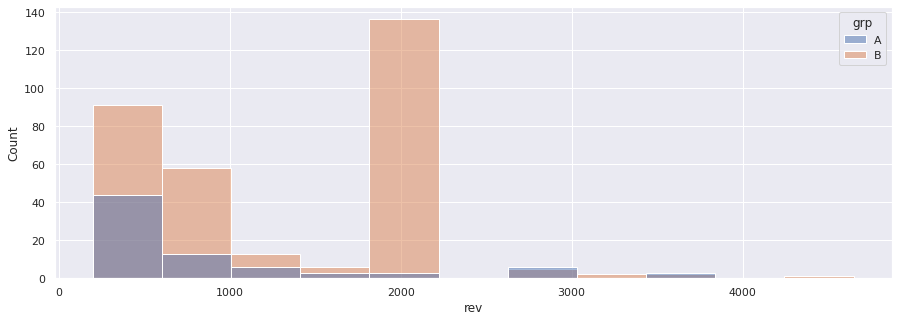

In [18]:
 #look at the distribution of payments for active users
sns.histplot(x='rev', hue='grp', data=all_active.query('rev > 0'))

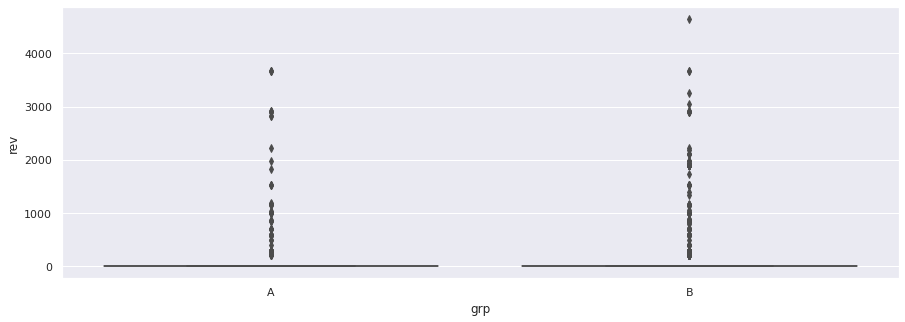

In [23]:
#we can see that the distribution is uneven, so we will check the outliers
sns.boxplot(data=all_active, y='rev',  x='grp')

The distribution is uneven, and there are outliers that can greatly affect the average value, so let's abandon the t-test. The Mann-Whitney U test is not suitable due to the complexity of interpretation, so we will use the bootstrap method.

### Metrics that we will consider:
* CR (Conversion Rate)
* ARPU (Average Revenue Per User)
* ARPPU (Average Revenue Per Paying User)

In [105]:
#calculate metrics
group_A = all_active.query("grp == 'A'")
group_B = all_active.query("grp == 'B'")

In [150]:
CR_A = group_A.payment.mean()
CR_B = group_B.payment.mean()

In [151]:
display (CR_A, CR_B)

0.05071521456436931

0.046156107599588415

In [149]:
ARPU_A = group_A.rev.mean()
ARPU_B = group_B.rev.mean()

In [110]:
display(ARPU_A, ARPU_B)

47.34720416124838

58.05879810377775

In [152]:
ARPPU_A = group_A.query('rev != 0').rev.mean()
ARPPU_B = group_B.query('rev != 0').rev.mean()

In [153]:
display(ARPPU_A, ARPPU_B)

933.5897435897435

1257.8789920382164

We can note that the CR in Group A is higher than in Group B. At the same time, ARPU and ARPPU, on the contrary, show the best result in Group B. It turns out that with the launching of the new payment mechanics, the CR decreases while the ARPU increases.

In [180]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    #visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins=70)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

#### CR. Hypotheses:
* Н0: CR is the same for both groups
* Н1: CR is different for both groups

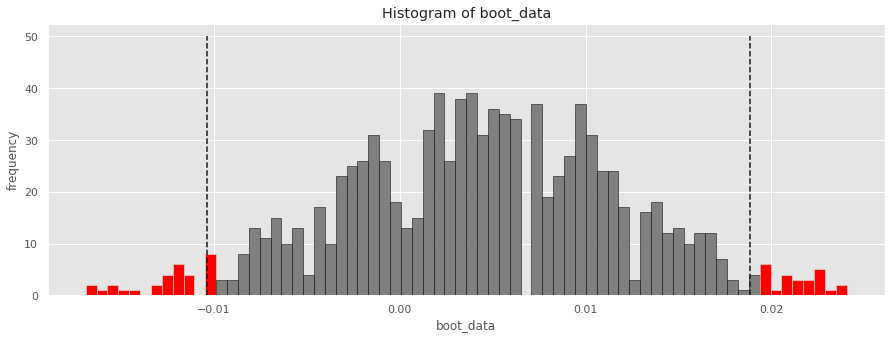

{'quants':               0
 0.025 -0.010403
 0.975  0.018872,
 'p_value': 0.5512098573744435}

In [181]:
get_bootstrap(group_A.payment, group_B.payment)

#### ARPU. Hypotheses:
* Н0: ARPU is the same for both groups
* Н1: ARPU is different for both groups

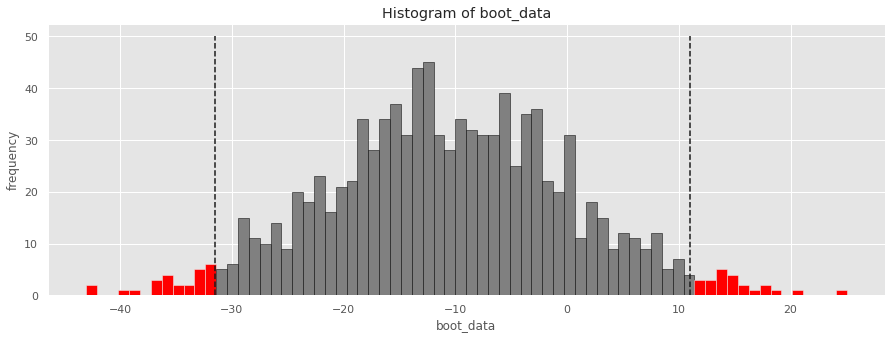

{'quants':                0
 0.025 -31.494182
 0.975  11.004405,
 'p_value': 0.32335866633829957}

In [182]:
get_bootstrap(group_A.rev, group_B.rev)

#### ARPPU. Hypotheses:
* Н0: ARPPU is the same for both groups
* Н1: ARPPU is different for both groups

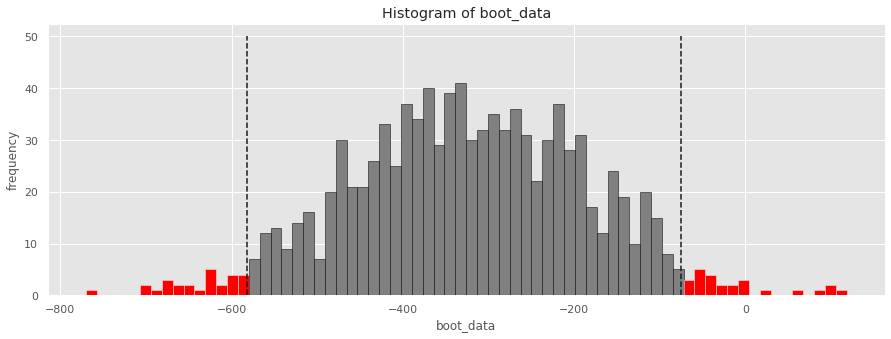

{'quants':                 0
 0.025 -581.610905
 0.975  -75.197128,
 'p_value': 0.017885944257032348}

In [179]:
get_bootstrap(group_A.rev[group_A.rev != 0], group_B.rev[group_B.rev != 0])

To sum up, bootstrap showed that the change in ARPPU is statistically significant, therefore we can reject the null hypothesis. At the same time, the change in CR is statistically insignificant, therefore we can reject the alternative hypothesis. The main problem is probably due to differences in sample sizes, so it would be better to enlarge the control group and re-run the tests. However, new payment mechanics can be launched, since ARPU and ARPPU are only growing.

### Task 2. SQL

#### 2.1 Diligent Students

#### Condition

Educational courses consist of various lessons, which, in turn, consist of several small tasks. Each such small task is called a "pea".

A diligent student is a user who solved 20 peas correctly at least once during the current month.

It is necessary to write an optimal query which provides information about the number of diligent students. NB! By diligent student, we mean a student who has correctly solved 20 problems in the current month.

In [3]:
#connect to clickhouse
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [191]:
q1 = '''
SELECT
    COUNT(DISTINCT st_id) AS diligent_students 
FROM
    (SELECT
        st_id,
        toStartOfMonth(timest) AS month,
        SUM(correct) AS peas
    FROM default.peas
    WHERE correct = 1
    GROUP BY 
            st_id,
            month
    HAVING peas >= 20)
'''
students = ph.read_clickhouse(query=q1, connection=connection)
students

,diligent_students
0,136


#### 2.2 Funnel optimization

#### Condition

The educational platform offers students to take courses based on the trial model: a student can solve only 30 peas a day for free. To have unlimited access to assignments, the student must purchase full access. The team conducted an experiment where they tested a new payment screen.

It is necessary to show the following information about user groups in one request:

* ARPU 
* ARPAU 
* CR
* СR for active users  
* CR for active math users (subject = ’math’) 

An active user is a user who has solved more than ten tasks correctly in all disciplines.

An active math user is a user who has solved two or more problems correctly in mathematics all the time.

In [4]:
q2 = '''
SELECT 
    test_group,
    ROUND(SUM(revenue) / COUNT(st_id), 2) AS ARPU,
    ROUND(SUM(active_pay) / SUM(sum_corr > 10), 2) AS ARPAU,
    ROUND(SUM(revenue > 0) / COUNT(st_id), 2) AS CR,
    ROUND(SUM(revenue > 0 AND sum_corr > 10) / SUM(sum_corr > 10), 2) AS CR_active,
    ROUND(SUM(math = 1 AND math_pay = 1) / SUM(math = 1), 2) AS CR_math
FROM
(
    SELECT 
        studs.st_id AS st_id, 
        studs.test_grp AS test_group,
        paid.revenue AS revenue,
        active_studs.sum_corr AS sum_corr,
        active_studs.math AS math,
        CASE WHEN sum_corr > 10 THEN paid.revenue ELSE 0 END AS active_pay,
        paid.math_pay AS math_pay
    FROM 
        default.studs
    LEFT JOIN 
    (SELECT
        st_id,
        SUM(money) AS revenue,
        MAX(CASE WHEN subject = 'Math' THEN 1 ELSE 0 END) AS math_pay
    FROM
        default.final_project_check
    GROUP BY st_id) AS paid 
    ON studs.st_id = paid.st_id
    LEFT JOIN
    (SELECT
          st_id,
          SUM(corr_num) AS sum_corr,
          SUM(active_math) AS math
    FROM
        (SELECT
            st_id,
            SUM(correct) AS corr_num,
            CASE WHEN subject = 'Math' AND corr_num >= 2 THEN 1 ELSE 0 END AS active_math
        FROM
            default.peas
        GROUP BY st_id, subject) 
    GROUP BY st_id) AS active_studs 
    ON studs.st_id = active_studs.st_id
)
GROUP BY test_group
'''

metrics = ph.read_clickhouse(query=q2, connection=connection)
metrics

,test_group,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10


### Task 3. Python

* Implement a function that automatically loads information from an additional groups_add.csv file (headers may vary) and recalculate metrics based on new parameters.

In [35]:
#read files
def yandex_disk(public_key):
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url) 
        download_url = response.json()['href'] 
        return download_url
    
groups_df = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
groups_add_df = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
active_studs_df = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks_df = pd.read_csv(yandex_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';') 

In [59]:
def get_update(groups_df, active_studs_df, checks_df):    
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    groups_add_df = pd.read_csv(download_url, sep=',') 
    
    all_groups = pd.concat([groups_df, groups_add_df]) \
                .drop_duplicates(subset='id') \
                .rename(columns={'id': 'student_id'})
    
    checks_df['payment'] = 1
    all_active = active_studs_df.merge(checks_df, how='left', on='student_id') \
                .merge(all_groups, how='left', on='student_id') \
                .fillna(0)
    
    group_A = all_active.query("grp == 'A'")
    group_B = all_active.query("grp == 'B'")
    CR_A = group_A.payment.mean()
    CR_B = group_B.payment.mean()
    ARPU_A = group_A.rev.mean()
    ARPU_B = group_B.rev.mean()
    ARPPU_A = group_A.query('rev != 0').rev.mean()
    ARPPU_B = group_B.query('rev != 0').rev.mean()
    
    metrics = pd.DataFrame({'group': ['A', 'B'], 'CR': [CR_A, CR_B], 'ARPU': [ARPU_A, ARPU_B], 'ARPPU': [ARPPU_A, ARPPU_B]})
    return metrics

In [60]:
df_metrics = get_update(groups_df, active_studs_df, checks_df)
df_metrics

,group,CR,ARPU,ARPPU
0,A,0.050715,47.347204,933.589744
1,B,0.046156,58.058798,1257.878992


* Implement a function that plots graphs based on the resulting metrics.

In [61]:
def get_plot(metrics):
    figure, ax = plt.subplots(1, 3, figsize=(20,5))
    
    ax_1 = sns.barplot(data=metrics, x='group', y='CR', ax=ax[0])
    ax_2 = sns.barplot(data=metrics, x='group', y='ARPU', ax=ax[1])
    ax_3 = sns.barplot(data=metrics, x='group', y='ARPPU', ax=ax[2])

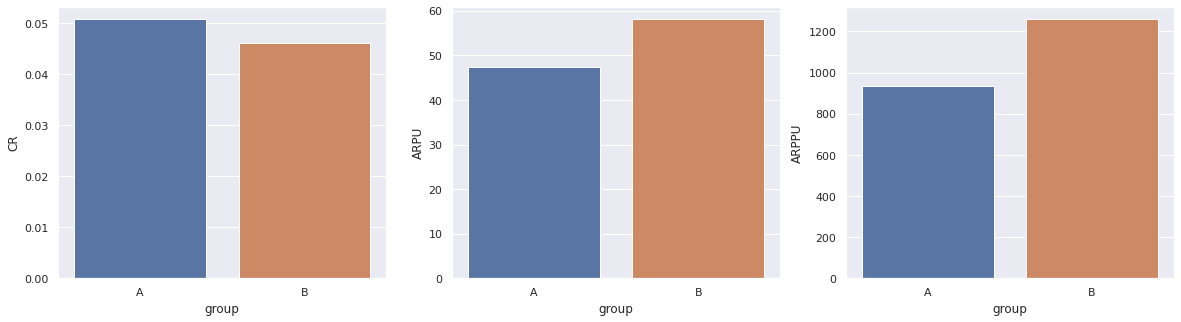

In [62]:
get_plot(df_metrics)